In [1]:
# import transformers
import sys
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from tqdm import tqdm
# from skimage.transform import resize
# from skimage.io import imread
from PIL import Image
import cv2
sys.path.insert(0, '../src')
from caption import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import pandas as pd

In [3]:

from tqdm import tqdm
from scipy import spatial
from sent2vec.vectorizer import Vectorizer

In [170]:
tqdm.pandas()

In [4]:
with open('../config/caption_local.json') as f:
    jsonread = json.load(f) 
    model_fp = jsonread['model_fp']
    wordmap_fp=jsonread['wordmap_fp']
    img_fp=jsonread['img_fp']
    beam_size=jsonread['beam_size']
    smooth=jsonread['smooth']

In [5]:
tqdm.pandas()

In [5]:
beam_size

5

In [6]:
import os
os.chdir('../src/')

In [7]:
# Load model
checkpoint = torch.load(model_fp, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval();

In [8]:
def get_viz(wordmap_fp, img_fp, beam_size, fname, smooth, visualize=True):
    # Load word map (word2ix)
    with open(wordmap_fp, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

#     Encode, decode with attention and beam search
#     seq, alphas = caption_image_beam_search(encoder, decoder, img_fp, word_map, beam_size)
    seq, alphas = caption_image_beam_search(encoder, decoder, img_fp, word_map, beam_size)
    alphas = torch.FloatTensor(alphas)
    
    words = [rev_word_map[ind] for ind in seq]
    # Visualize caption and attention of best sequence
#     visualize_att(img_fp, seq, alphas, rev_word_map, fname, smooth)
    if visualize == True: visualize_att(img_fp, seq, alphas, rev_word_map, fname, smooth)
    return ' '.join(words[1:-1])

In [11]:
# def get_attention_maps(wordmap_fp, img_fp, beam_size, fname, smooth):

In [9]:
def compare_two_sentences(sentence_1, sentence_2):
    sentences = [sentence_1, sentence_2]
    
    vectorizer = Vectorizer()
    vectorizer.bert(sentences)
    vec_1, vec_2 = vectorizer.vectors
    
    dist = spatial.distance.cosine(vec_1, vec_2)
    return dist

0.029322445392608643

In [13]:
pwd

'/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/src'

In [10]:
smooth = False

In [13]:
### NOTE: Counterfactual production has to be in another class...

In [14]:
class CounterfactualGenerator(object):
    def __init__(self, img_dir, out_dir, model_dir):
        ...
    
    def _get_
    

SyntaxError: invalid syntax (<ipython-input-14-6d2fbf558b63>, line 5)

In [171]:
class ImageCaptionExplainer(object):
    def __init__(self, img_dir, out_dir, model_fp, wordmap_fp, model_dir, beam_size=5):
        self.img_dir = img_dir
        self.out_dir = out_dir
        self.raw_imgs = self._get_raw_imgs()
        self.img_ids = [int(i.split('/')[-2].split('_')[-1]) for i in self.raw_imgs]
#         self.counterfactuals = self._get_counterfactual_imgs()
        with open(wordmap_fp, 'r') as j:
            word_map = json.load(j)
        self.word_map = word_map
        self.rev_word_map = {v: k for k, v in self.word_map.items()}  # ix2word
        self.encoder, self.decoder = self._load_model()
        self.beam_size = beam_size
        
        self.alphas, self.seqs = self._get_alphas_seqs()
#         self.seqs = {}
        self.ids = self._get_img_ann_ids()
        self.model_dir = model_dir
        
        
#     # Visualize caption and attention of best sequence
# #     visualize_att(img_fp, seq, alphas, rev_word_map, fname, smooth)
#     if visualize == True: visualize_att(img_fp, seq, alphas, rev_word_map, smooth)
#     return ' '.join(words[1:-1])

    def __repr__(self):
        return f'ImageCaptionExplainer(img_dir=\'{self.img_dir}\', out_dir=\'{self.out_dir}\')'        
    
    def _get_img_ann_ids(self):
        ids = {}
#         ann_ids = []
        for idx, img in enumerate(self.img_ids):
            ids[img] = []
            load_fp = f'{self.img_dir}/{img}/counterfactuals'
            # get raw alphas, seq
            # get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
            for i, ann in enumerate(os.listdir(load_fp)):
                # get counterfactual captions
                if 'raw' in ann or 'auto' in ann: continue
                ann_id = int(ann.split('_')[-1].strip('.png'))
#                 ann_ids.append(ann_id)
                ann_fp = load_fp + ann
                ids[img].append(ann_id)
            ids[img] = list(set(ids[img]))
#                 self.alphas[ann_id], self.seqs[ann_id] = caption_image_beam_search(self.encoder, self.decoder, ann, self.word_map, self.beam_size)
#         self.ann_ids = ann_ids
#         ids
        return ids
        
        
    def _get_alphas_seqs(self):
#         ann_ids = []
        #  Encode, decode with attention and beam search
        seqs = {}
        alphas = {}
        for idx, img in enumerate(self.img_ids):
            load_fp = f'{self.img_dir}/{img}/'
            # get raw alphas, seq
            try:
                img_fp = load_fp + 'raw.png'
                seqs[img], alphas[img] = caption_image_beam_search(self.encoder, self.decoder, img_fp, self.word_map, self.beam_size)

            except FileNotFoundError:
                img_fp = load_fp + f'raw_{img}.png'
                seqs[img], alphas[img] = caption_image_beam_search(self.encoder, self.decoder, img_fp, self.word_map, self.beam_size)
            # get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
            for i, ann in enumerate(os.listdir(f'{self.out_dir}/{img}/counterfactuals')):
                # get counterfactual captions
                if 'raw' in ann or 'maps' in ann or 'auto' in ann: continue
                ann_id = int(ann.split('_')[-1].strip('.png'))
                ann_fp = f'{self.out_dir}/{img}/counterfactuals/{ann}'
                seqs[ann_id], alphas[ann_id] = caption_image_beam_search(self.encoder, self.decoder, ann_fp, self.word_map, self.beam_size)
#         self.ann_ids = ann_ids
        return alphas, seqs

    def word_alpha_tuple(self, img_id):
#         word_alpha = {}
        words = [self.rev_word_map[ind] for ind in self.seqs[img_id][1:-1]]
        alphas = self.alphas[img_id][1:-1]
        print(f'word, alpha length: {(len(words), len(alphas))}')
        assert len(words) == len(alphas), f'{len(words)} != {len(alphas)}'
        return tuple(zip(words, alphas))

    def _get_caption(self, img_id):
#         print(img_fp)
#         img_id = int(img.split('/')[-2])
        words = [self.rev_word_map[ind] for ind in self.seqs[img_id]]
        caption = ' '.join(words[1:-1])
#         self.seq = ' '.join(words[1:-1])
        return caption
    
    def _load_model(self):
        # Load model
        checkpoint = torch.load(model_fp, map_location=str(device))
        decoder = checkpoint['decoder']
        decoder = decoder.to(device)
        decoder.eval()
        encoder = checkpoint['encoder']
        encoder = encoder.to(device)
        encoder.eval();
        return encoder, decoder
        
    def _get_raw_imgs(self):
        raw_imgs = []
#         caption_dict = {}
        for img_folder in (os.listdir(self.img_dir)):
            load_fp = f'{self.img_dir}/{img_folder}'
            for file in (os.listdir(f'{self.img_dir}/{img_folder}')):
                in_fp = f'{load_fp}/{file}'
                if 'raw' in file:
                    raw_imgs.append(in_fp)
        return raw_imgs
    
    
    def produce_counterfactuals(self, img_id):
        anns = self.ids[img_id]
        for ann_id in img_caption.ids[img_id]:
            !./generate_counterfactual.sh {img_dir} {out_dir} {img_id} {ann_id} {model_dir}
    
    def _get_counterfactual_imgs(self):
        ann_imgs = [] 
        for img_folder in os.listdir(self.out_dir):
            load_fp = f'{self.out_dir}/{img_folder}'
            for file in (os.listdir(f'{self.out_dir}/{img_folder}')):
                in_fp = load_fp+'/'+file
                out_fp = self.out_dir+'/'+img_folder+'/'
                if 'output' in file:
                    ann_imgs.append(in_fp)
#                     ann_id = file.split('_')[-1].strip('.png')
#                     out_fp+=f'maps_{ann_id}.png'
#                     words = get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
        return ann_imgs
        
    def _get_img_caption(self, img_id, img_caption_dict, ann_caption_dict):
        load_fp = f'{self.img_dir}/{img_id}/counterfactuals'
        # get raw img captions
        img_caption_dict[img_id] =  self._get_caption(img_id)  
        # get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
        for i, ann in enumerate(os.listdir(load_fp)):
            # get counterfactual captions
            if 'raw' in ann or 'auto' in ann: continue
            ann_id = int(ann.split('_')[-1].strip('.png'))
#                 out_fp+=f'maps_{ann_id}.png'
            ann_fp = load_fp + ann
            words = self._get_caption(ann_id)
            ann_caption_dict[(img_id, ann_id)] = [words]
        return img_caption_dict, ann_caption_dict
        
    def _get_captions(self, img_id=None):
        img_caption_dict = {}
        ann_caption_dict = {}
        if img_id is not None:
            return self._get_img_caption(img_id, img_caption_dict, ann_caption_dict)
        
        for idx, img in enumerate(self.img_ids):
            img_caption_dict, ann_caption_dict = self._get_img_caption(img, img_caption_dict, ann_caption_dict)
        return img_caption_dict, ann_caption_dict
        
#     def _get_captions(self, img_dir, out_dir):
#         caption_dict = {}
#         for img_folder in tqdm(os.listdir(img_dir)):
#             load_fp = img_dir+'/'+img_folder
#             for file in (os.listdir(f'{img_dir}/{img_folder}')):
#                 in_fp = load_fp+'/'+file
#                 out_fp = out_dir+'/'+img_folder+'/'
#                 if 'raw' in file and 'out' not in img_dir:
#                     out_fp+=f'maps_raw_{img_folder}.png'
#                     caption_dict[int(img_folder)] = get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
#                 if 'output' in file:
#                     ann_id = file.split('_')[-1].strip('.png')
#                     out_fp+=f'maps_{ann_id}.png'
#                     words = get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
#                     caption_dict[(int(img_folder), int(ann_id))] = [words]
#         return caption_dict
    
    def get_bert_similarities(self, img_id=None):
        raw_caption_dict, ann_caption_dict = self._get_captions(img_id)
#         ann_caption_dict = self._get_captions(self.out_dir, self.out_dir)

        ann_df = pd.DataFrame(ann_caption_dict).transpose().reset_index().rename(columns={0:'ann_caption'})
        caption_df = pd.Series(raw_caption_dict).to_frame().rename(columns={0:'raw_caption'}).merge(ann_df, left_index=True, right_on='level_0')
        caption_df = caption_df.rename(columns={'level_0':'img_id', 'level_1':'ann_id'})
#         print(caption_df)
        caption_df.loc[(caption_df['raw_caption'] == caption_df['ann_caption']), 'dist_from_raw'] = 0
        if caption_df['dist_from_raw'].isnull().sum() > 0:
            caption_df.loc[list(caption_df['dist_from_raw'].isnull().index), 'dist_from_raw'] = \
                caption_df.loc[(caption_df['dist_from_raw'].isnull())].progress_apply(lambda x: compare_two_sentences(x['raw_caption'], x['ann_caption']), axis=1)
            caption_df['dist_from_raw'] = caption_df['dist_from_raw'].fillna(0)
        self.caption_similarities = caption_df
        return caption_df
    
    def get_attention_maps(self):
        seq, alphas = caption_image_beam_search(encoder, decoder, img_fp, word_map, beam_size)
        self.attention_maps = alphas

In [172]:
%time img_caption = ImageCaptionExplainer('../data/temp/test_imgs', '../data/temp/test_imgs', model_fp=model_fp, wordmap_fp=wordmap_fp, model_dir='full_model_coco2017_v2')

CPU times: user 26.9 s, sys: 319 ms, total: 27.2 s
Wall time: 3.58 s


In [13]:
# img_caption.produce_counterfactuals(569158)

In [84]:
img_caption.ids[31093]

[1475365, 2157893, 638282, 1233457, 1421746, 453234]

In [113]:
raw_alpha_tuple = img_caption.word_alpha_tuple(569158)

word, alpha length: (8, 8)


In [114]:
ann_alpha_tuple = img_caption.word_alpha_tuple(204069)

word, alpha length: (10, 10)


In [115]:
def distance(x, y):
    ret = np.sqrt(sum((x-y) ** 2))
    return ret

['a', 'man', 'and', 'a', 'dog', 'on', 'a', 'sidewalk']

In [150]:
raw_caption = ' '.join([raw_alpha_tuple[i][0] for i in range(len(raw_alpha_tuple))])
ann_caption = ' '.join([ann_alpha_tuple[i][0] for i in range(len(ann_alpha_tuple))])

In [151]:
distances = np.zeros(max(len(raw_alpha_tuple), len(ann_alpha_tuple)))
# c = 0
if len(raw_alpha_tuple) > len(ann_alpha_tuple):
    bigger_tuple = raw_alpha_tuple
    smaller_tuple = ann_alpha_tuple
else:
    bigger_tuple = ann_alpha_tuple
    smaller_tuple = raw_alpha_tuple

for i, word_alpha_i in enumerate(bigger_tuple):
    for j, word_alpha_j in enumerate(smaller_tuple):
        if word_alpha_i[0] == word_alpha_j[0]:
            a, b = np.array(word_alpha_i[1]), np.array(word_alpha_j[1])
            dist_alphas = sum(distance(a, b)) / 14
            distances[i] = dist_alphas
            print(f'dist_alphas: {dist_alphas}')
            break
#         else:
#             dist_bert = compare_two_sentences(word_alpha_i[0], word_alpha_j[0])
#             print(f'dist_bert: {dist_bert}')
#             distances[i] = dist_bert

dist_alphas: 0.009664113092297779
dist_alphas: 0.0199088771333324
dist_alphas: 0.014272263874422108
dist_alphas: 0.046875735387227446


In [149]:
sum(distances)

0.09072098948727973

In [153]:
sys.path.insert(0, '../src/data/cocoapi/PythonAPI/')
from pycocotools.coco import COCO

In [154]:
coco = COCO('../data/raw/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=6.31s)
creating index...
index created!


In [193]:
anns =sorted(img_caption.ids[569158])

In [194]:
ann_lst = coco.loadAnns(anns)

In [197]:
coco.showAnns?

In [192]:
# from matplotlib.patches import Polygon
# from matplotlib.collections import PatchCollection
# def showAnns(anns, vals, draw_bbox=False):
#     """
#     Display the specified annotations.
#     :param anns (array of object): annotations to display
#     :return: None
#     """
#     if len(anns) == 0:
#         return 0
#     if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
#         datasetType = 'instances'
#     elif 'caption' in anns[0]:
#         datasetType = 'captions'
#     else:
#         raise Exception('datasetType not supported')
#     if datasetType == 'instances':
#         ax = plt.gca()
#         ax.set_autoscale_on(False)
#         polygons = []
#         color = []
#         for i, ann in enumerate(anns):
#             c = anns[i] #(np.random.random((1, 3))*0.6+0.4).tolist()[0]
#             if 'segmentation' in ann:
#                 if type(ann['segmentation']) == list:
#                     # polygon
#                     for seg in ann['segmentation']:
#                         poly = np.array(seg).reshape((int(len(seg)/2), 2))
#                         polygons.append(Polygon(poly))
#                         color.append(c)
                        
#             if 'keypoints' in ann and type(ann['keypoints']) == list:
#                     # turn skeleton into zero-based index
#                     sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
#                     kp = np.array(ann['keypoints'])
#                     x = kp[0::3]
#                     y = kp[1::3]
#                     v = kp[2::3]
#                     for sk in sks:
#                         if np.all(v[sk]>0):
#                             plt.plot(x[sk],y[sk], linewidth=3, color=c)
#                     plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
#                     plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)


#         p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
#         ax.add_collection(p)
#         p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
#         ax.add_collection(p)
#     elif datasetType == 'captions':
#         for ann in anns:
#             print(ann['caption'])

In [175]:
anns

[641194, 204069, 1367957, 8175]

In [177]:
caption_df = img_caption.get_bert_similarities(569158).sort_values(by='ann_id')

100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


In [198]:
caption_df

raw_caption  img_id   ann_id  \
2  a man and a dog on a sidewalk  569158     8175   
3  a man and a dog on a sidewalk  569158   204069   
0  a man and a dog on a sidewalk  569158   641194   
1  a man and a dog on a sidewalk  569158  1367957   

                                       ann_caption  dist_from_raw  
2    a man sitting on the ground with a skateboard       0.042431  
3       a dog laying on the ground next to a truck       0.084474  
0           a man and a dog playing with a frisbee       0.103348  
1  a man kneeling down next to a dog on a sidewalk       0.074369

In [183]:
vals = caption_df['dist_from_raw']

ValueError: RGBA sequence should have length 3 or 4

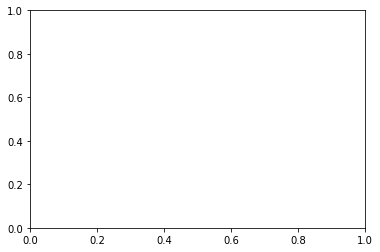

In [191]:
showAnns(ann_lst, vals)

In [152]:
compare_two_sentences(raw_caption, ann_caption)

0.08447420597076416

In [119]:
(raw_alpha_tuple)

8

In [70]:
%%time
for idx, key in enumerate(raw_alpha_dict):
    if list(ann_alpha_dict.keys())[idx] == list(raw_alpha_dict.keys())[idx]:
        a = np.array(ann_alpha_dict[key])
        b = np.array(raw_alpha_dict[key])

        dist = sum(distance(a, b))
        print(f'distance: {dist, key}')

distance: (0.21748336440074426, 'a')
distance: (0.30632539606635273, 'man')
distance: (0.2345517045086672, 'riding')
distance: (0.16049256202591655, 'skateboard')
distance: (0.12594937144058763, 'up')
distance: (0.135441213388443, 'the')
distance: (0.18960565283033806, 'side')
distance: (0.15360258098931556, 'of')
distance: (0.20678097912236323, 'ramp')
CPU times: user 0 ns, sys: 952 µs, total: 952 µs
Wall time: 555 µs


In [19]:
raw_attn_map = img_caption.alphas[31093][]

In [33]:
img_caption.alphas

{31093: [[[1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [31]:
caption_df = img_caption.get_bert_similarities(31093)
len(caption_df['raw_caption'].unique()[0].split())

11

In [32]:
len(raw_attn_map[1:-1])

11

In [20]:
for ann_id in img_caption.ids[31093]:
    print
#     !./generate_counterfactual.sh {img_caption.img_dir} {img_caption.out_dir} 569158 {ann_id} {img_caption.model_dir}


../data/temp/imgs
../data/temp/imgs/569158/input_641194.png
../data/temp/imgs/569158/mask_641194.png
../data/out/569158/output_641194.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

Model loaded.
../data/temp/imgs
../data/temp/imgs/569158/input_1367957.png
../data/temp/imgs/569158/mask_1367957.png
../data/out/569158/output_1367957.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, 

Model loaded.


In [13]:
img_caption.img_ids

[31093,
 569158,
 311909,
 466156,
 295316,
 491464,
 551215,
 548555,
 326542,
 25394,
 316617,
 316617,
 455624]

In [75]:
cap_df_2 = img_caption.get_bert_similarities(491464)

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


In [76]:
cap_df_2

raw_caption  img_id   ann_id  \
0   a young boy holding a baseball bat on a field  491464  1382027   
1   a young boy holding a baseball bat on a field  491464  1385051   
2   a young boy holding a baseball bat on a field  491464  1343081   
3   a young boy holding a baseball bat on a field  491464  1345512   
4   a young boy holding a baseball bat on a field  491464  1339021   
5   a young boy holding a baseball bat on a field  491464  2044396   
6   a young boy holding a baseball bat on a field  491464  1357559   
7   a young boy holding a baseball bat on a field  491464  2041265   
8   a young boy holding a baseball bat on a field  491464   629786   
9   a young boy holding a baseball bat on a field  491464  2043134   
10  a young boy holding a baseball bat on a field  491464  1383630   
11  a young boy holding a baseball bat on a field  491464  1776076   
12  a young boy holding a baseball bat on a field  491464   437864   

                                      ann_caption  dist_from_raw  
0   a young boy holding a baseball bat on a field       0.000000  
1   a young boy holding a baseball bat on a field       0.000000  
2   a young boy holding a baseball bat on a field       0.000000  
3   a young boy holding a baseball bat on a field       0.000000  
4   a young boy holding a baseball bat on a field       0.000000  
5   a young boy holding a baseball bat on a field       0.000000  
6   a young boy holding a baseball bat on a field       0.000000  
7   a young boy holding a baseball bat on a field       0.000000  
8   a young boy holding a baseball bat on a field       0.000000  
9   a young boy holding a baseball bat on a field       0.000000  
10  a young boy holding a baseball bat on a field       0.000000  
11  a young boy holding a baseball bat on a field       0.000000  
12     a baseball player holding a bat on a field       0.067842

In [21]:
get_viz?

In [28]:
pwd

'/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/src'

In [30]:
img_dir = '/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/data/raw/raw_images/COCO_train2014_000000569158.jpg'

get_viz(wordmap_fp, img_dir, 5, f'maps_raw.png', True, True)

../src/caption.py:176: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)


'a man and a dog on a sidewalk'

In [27]:

img_dir = '/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/data/out/569158/'

for file in os.listdir(img_dir):
#     get_viz()
    ann_id = file.strip('.png').split('_')[-1]
    get_viz(wordmap_fp, img_dir+'/'+file, 5, f'maps_{ann_id}.png', True, True)

../src/caption.py:176: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)


In [74]:
cap_df

raw_caption  img_id   ann_id  \
0  a cat sitting on the hood of a car  466156  1358425   
1  a cat sitting on the hood of a car  466156  1344825   
2  a cat sitting on the hood of a car  466156   135585   
3  a cat sitting on the hood of a car  466156   243663   
4  a cat sitting on the hood of a car  466156    47170   

                                         ann_caption  dist_from_raw  
0                 a cat sitting on the hood of a car       0.000000  
1                 a cat sitting on the hood of a car       0.000000  
2  a black and white dog standing next to a black...       0.031496  
3                 a cat sitting on the hood of a car       0.000000  
4  a couple of motorcycles parked next to each other       0.076799

In [206]:
# alphas = np.array(img_caption.alphas[316617])
img_id = img_caption.img_ids[2]
alphas = np.array(img_caption.alphas[img_id])
for alpha in alphas:
#     pd.DataFrame(alpha)
    print('Min value:',alpha.min())
    print('25th percentile:', np.percentile(alpha, 25))
#     print('Median value:',alpha.median())
    print('Mean value:',alpha.mean())
    print('75th percentile:', np.percentile(alpha, 75))
    print('Max value:',alpha.max())
    print()

Min value: 1.0
25th percentile: 1.0
Mean value: 1.0
75th percentile: 1.0
Max value: 1.0

Min value: 2.9142835700213254e-08
25th percentile: 0.0003203983942512423
Mean value: 0.005102040930244966
75th percentile: 0.005096795153804123
Max value: 0.06525356322526932

Min value: 8.594106475356966e-06
25th percentile: 0.0004692544025601819
Mean value: 0.005102040686059976
75th percentile: 0.006481730146333575
Max value: 0.04502095282077789

Min value: 6.948645022930577e-05
25th percentile: 0.0018167183734476566
Mean value: 0.005102040669730834
75th percentile: 0.006945601780898869
Max value: 0.0178964976221323

Min value: 1.0555785593169276e-05
25th percentile: 0.0011601134901866317
Mean value: 0.005102041069950265
75th percentile: 0.007762274355627596
Max value: 0.018695835024118423

Min value: 9.350779919259367e-07
25th percentile: 0.00044648587208939716
Mean value: 0.005102040922697969
75th percentile: 0.006904324400238693
Max value: 0.026776937767863274

Min value: 6.332244311124668e-07

In [207]:
np.where?

In [263]:
viz_alphas[0].shape

(14, 14)

In [350]:
image.size

(500, 375)

In [504]:
def attn_map_counterfactuals(img_caption, img_id, iters=5):
    for i in range(iters):
        if i == 0:
            try: raw_fp = f'{img_caption.img_dir}/{img_id}/raw.png'
            except FileNotFoundError: raw_fp =f'{img_caption.img_dir}/{img_id}/raw_{img_id}.png'
            seq, alphas = caption_image_beam_search(encoder, decoder, raw_fp, img_caption.word_map, img_caption.beam_size)
        else:
            counter_fp = f'{img_caption.out_dir}/{img_id}/output_{img_id}_auto{i}.png'
            seq, alphas = caption_image_beam_search(encoder, decoder, counter_fp, img_caption.word_map, img_caption.beam_size)
        viz_alphas = np.array(alphas).copy()
        # threshold = 0.01
        # viz_alphas[alphas>=threshold] = 1
        # viz_alphas[alphas<threshold] = 0
        img_shape = image.size[::-1]
        tot_alphas = np.zeros(img_shape)
        for j in range(1, len(viz_alphas)):
            viz_alpha = viz_alphas[j,:]

        #     threshold = viz_alpha.mean() + 1* viz_alpha.std()

        #     viz_alpha[viz_alpha>=threshold] = 1
        #     viz_alpha[viz_alpha<threshold] = 0
        #     viz_alpha = skimage.transform.pyramid_expand(viz_alpha, upscale=24, sigma=8)
            viz_alpha = skimage.transform.resize(viz_alpha, img_shape)
        #     print(viz_alpha.shape)
            tot_alphas += viz_alpha
        #     print(np.mean(tot_alphas))
        threshold = tot_alphas.mean() + 1* tot_alphas.std()
        tot_alphas[tot_alphas<threshold] = 0
        tot_alphas[tot_alphas>=threshold] = 255


        mask = Image.fromarray(tot_alphas)
        mask_fname = f'../data/temp/imgs/{img_id}/mask_{img_id}_auto{i+1}.png' ### CHANGE 1 TO i
        print(mask_fname)
#         print(os.getcwd())
        if mask.mode != 'L':
            mask = mask.convert('L')

        if i == 0:
            try: raw_cv = cv2.imread(f'{img_caption.img_dir}/{img_id}/raw.png')
            except FileNotFoundError: raw_cv = cv2.imread(f'{img_caption.img_dir}/{img_id}/raw_{img_id}.png')
        else:
            raw_cv = cv2.imread(f'{img_caption.out_dir}/{img_id}/output_{img_id}_auto{i}.png')
        
        if mask.size != raw_cv.shape[::-1][1:]:
            mask = mask.resize(raw_cv.shape[::-1][1:])
        print('raw_cv shape first:',raw_cv.shape[::-1][1:])
        print('mask size: ',mask.size)
        mask.save(mask_fname)
        print(f'{mask_fname} saved')

        
#         print(raw_cv)
        #     raw_fname = f'imgs/{img_id}/raw_{img_id}.png'
        # img.save(raw_fname)
        # print(f'{raw_fname} saved')

        # raw_cv = cv2.imread(f'imgs/{img_id}/raw.png')
        raw_cv = cv2.cvtColor(raw_cv, cv2.COLOR_BGR2RGB)
        
        mask_cv = cv2.imread(mask_fname)
        
        if raw_cv.shape != mask_cv.shape:
            print(f'raw_cv shape: {raw_cv.shape}')
            print(f'mask_cv shape: {mask_cv.shape}')
            mask_cv = cv2.resize(mask_cv, raw_cv.shape[::-1][1:])
            print(f'(new) mask_cv shape: {mask_cv.shape}\n')
            
        input_cv = cv2.add(raw_cv, mask_cv)
        print('actual input_shape:',input_cv.shape)
        input_cv = Image.fromarray(input_cv)
        input_fname = f'../data/temp/imgs/{img_id}/input_{img_id}_auto{i+1}.png'
        input_cv.save(input_fname)
        mask_img = f'{img_id}_auto{i+1}'
        print('input size:',input_cv.size)

        !./generate_counterfactual.sh {img_caption.img_dir} {img_caption.out_dir} {img_id} {mask_img} {img_caption.model_dir}

In [505]:
# cv2.imread(f'{img_caption.img_dir}/{img_id}/raw.png')

In [506]:
%time attn_map_counterfactuals(img_caption, 466156)

../data/temp/imgs/466156/mask_466156_auto1.png
raw_cv shape first: (500, 375)
mask size:  (500, 375)
../data/temp/imgs/466156/mask_466156_auto1.png saved
actual input_shape: (375, 500, 3)
input size: (500, 375)
../data/temp/imgs
../data/temp/imgs/466156/input_466156_auto1.png
../data/temp/imgs/466156/mask_466156_auto1.png
../data/out/466156/output_466156_auto1.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/h

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model loaded.
../data/temp/imgs/466156/mask_466156_auto3.png
raw_cv shape first: (496, 368)
mask size:  (496, 368)
../data/temp/imgs/466156/mask_466156_auto3.png saved
actual input_shape: (368, 496, 3)
input size: (496, 368)
../data/temp/imgs
../data/temp/imgs/466156/input_466156_auto3.png
../data/temp/imgs/466156/mask_466156_auto3.png
../data/out/466156/output_466156_auto3.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model loaded.
../data/temp/imgs/466156/mask_466156_auto5.png
raw_cv shape first: (496, 368)
mask size:  (496, 368)
../data/temp/imgs/466156/mask_466156_auto5.png saved
actual input_shape: (368, 496, 3)
input size: (496, 368)
../data/temp/imgs
../data/temp/imgs/466156/input_466156_auto5.png
../data/temp/imgs/466156/mask_466156_auto5.png
../data/out/466156/output_466156_auto5.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [526]:
iters = 5
alpha_lst = []
word_lst = []
for i in range(iters):
    counter_fp = f'{img_caption.out_dir}/{img_id}/output_{img_id}_auto{i+1}.png'
    seq, alphas = caption_image_beam_search(encoder, decoder, counter_fp, img_caption.word_map, beam_size)
    words = [img_caption.rev_word_map[ind] for ind in seq]
#     words = ' '.join(words[1:-1])
    word_lst.append(words[1:-1])
    alpha_lst.append(alphas[1:-1])

In [528]:
def distance(x, y):
    ret = np.sqrt(sum((x-y) ** 2))
    return ret

In [531]:
caption1

['a', 'black', 'cat', 'sitting', 'on', 'the', 'hood', 'of', 'a', 'car']

In [532]:
caption2

['a', 'cat', 'sitting', 'on', 'the', 'hood', 'of', 'a', 'car']

In [539]:
caption1 = word_lst[0]
alpha1 = np.array(alpha_lst[0])

caption2 = word_lst[1]
alpha2 = np.array(alpha_lst[1])

distances = np.zeros(max(len(caption1), len(caption2)))

for i, word1 in enumerate(caption1):
    for j, word2 in enumerate(caption2):
        if word1 == word2: # compare the alphas when this happens
            distances[i] = (distance(alpha1[i].flatten(), alpha2[j].flatten()))

In [540]:
distances

array([0.1391054 , 0.        , 0.08650184, 0.04973422, 0.05395648,
       0.05144882, 0.07053845, 0.03053301, 0.07437882, 0.08343972])

In [516]:
pd.DataFrame(word_alpha_dict)

a black cat sitting on the hood of a car
0   [[0.026040468364953995, 0.020379602909088135, ...
1   [[7.746976189082488e-05, 0.0001364432391710579...
2   [[0.0003278320364188403, 0.0004399333265610039...
3   [[0.0004793668631464243, 0.0005070980987511575...
4   [[0.0010521680815145373, 0.0011527611641213298...
5   [[0.0008313985308632255, 0.0004001862835139036...
6   [[0.0005667927325703204, 0.0003879462019540369...
7   [[0.003066088305786252, 0.002523640403524041, ...
8   [[0.00011143121082568541, 8.234172855736688e-0...
9   [[0.0001200260958285071, 7.807259680703282e-05...
10  [[0.0021156533621251583, 0.0019464152865111828...

In [380]:
threshold

0.08120294047687227

In [381]:
image = Image.open(f'../data/temp/imgs/{img_id}/raw.png')
# image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)


In [385]:
img_id

466156

In [389]:
tot_alphas.shape

(375, 500)

In [390]:
mask.mode

'F'

In [397]:
mask = Image.fromarray(tot_alphas)
mask_fname = f'../data/temp/imgs/{img_id}/mask_{img_id}_auto1.png'
print(mask_fname)
print(os.getcwd())
if mask.mode != 'L':
    mask = mask.convert('L')

mask.save(mask_fname)
print(f'{mask_fname} saved')



../data/temp/imgs/466156/mask_466156_auto1.png
/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/src
../data/temp/imgs/466156/mask_466156_auto1.png saved


In [398]:
try: raw_cv = cv2.imread(f'../data/temp/imgs/{img_id}/raw.png')
except FileNotFoundError: raw_cv = cv2.imread(f'../data/temp/imgs/{img_id}/raw_{img_id}.png')
#     raw_fname = f'imgs/{img_id}/raw_{img_id}.png'
# img.save(raw_fname)
# print(f'{raw_fname} saved')

# raw_cv = cv2.imread(f'imgs/{img_id}/raw.png')
raw_cv = cv2.cvtColor(raw_cv, cv2.COLOR_BGR2RGB)
mask_cv = cv2.imread(mask_fname)

input_cv = cv2.add(raw_cv, mask_cv)
input_cv = Image.fromarray(input_cv)
input_fname = f'../data/temp/imgs/{img_id}/input_{img_id}_auto1.png'
input_cv.save(input_fname)

In [399]:
mask_img = f'{img_id}_auto1'

In [22]:
img_caption.get_bert_similarities()

KeyError: '../data/temp/imgs/31093/raw.png'

In [400]:
!./generate_counterfactual.sh {img_caption.img_dir} {img_caption.out_dir} {img_id} {mask_img} {img_caption.model_dir}

../data/temp/imgs
../data/temp/imgs/466156/input_466156_auto1.png
../data/temp/imgs/466156/mask_466156_auto1.png
../data/out/466156/output_466156_auto1.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy,

In [406]:
counter_fp = f'{img_caption.out_dir}/{img_id}/output_{img_id}_auto1.png'
seq, alphas = caption_image_beam_search(encoder, decoder, counter_fp, img_caption.word_map, beam_size)
words = [img_caption.rev_word_map[ind] for ind in seq]
caption = ' '.join(words[1:-1])

In [407]:
words = [img_caption.rev_word_map[ind] for ind in seq]
caption = ' '.join(words[1:-1])

In [412]:
alphas[1,:]

TypeError: list indices must be integers or slices, not tuple

In [413]:
viz_alphas = np.array(alphas).copy()
# threshold = 0.01
# viz_alphas[alphas>=threshold] = 1
# viz_alphas[alphas<threshold] = 0
img_shape = image.size[::-1]
tot_alphas = np.zeros(img_shape)
for i in range(1, len(viz_alphas)):
    viz_alpha = viz_alphas[i,:]
    
#     threshold = viz_alpha.mean() + 1* viz_alpha.std()
    
#     viz_alpha[viz_alpha>=threshold] = 1
#     viz_alpha[viz_alpha<threshold] = 0
#     viz_alpha = skimage.transform.pyramid_expand(viz_alpha, upscale=24, sigma=8)
    viz_alpha = skimage.transform.resize(viz_alpha, img_shape)
#     print(viz_alpha.shape)
    tot_alphas += viz_alpha
#     print(np.mean(tot_alphas))
threshold = tot_alphas.mean() + 1* tot_alphas.std()
tot_alphas[tot_alphas<threshold] = 0
tot_alphas[tot_alphas>=threshold] = 255

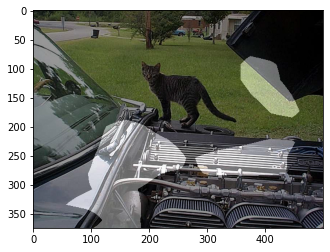

In [417]:
plt.imshow(image)
plt.imshow(tot_alphas, alpha=.5)

In [408]:
caption

'a black cat sitting on the hood of a car'

In [ ]:
! ./generate_counterfactual.sh {img_caption.}

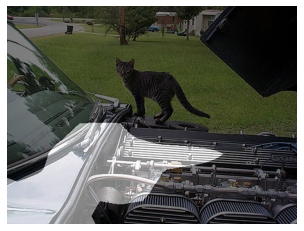

In [370]:
plt.set_cmap(cm.Greys_r)
#         plt.set_cmap(cm.seismic)
plt.axis('off')

plt.imshow(image)
plt.imshow(tot_alphas, alpha=.5);
plt.savefig('../data/temp/imgs/466156/test.png');

In [275]:
# viz_alphas[7, :]

In [87]:
alpha_smooth = skimage.transform.pyramid_expand(np.array(img_caption.alphas[316617])[1,:], upscale=24, sigma=8)

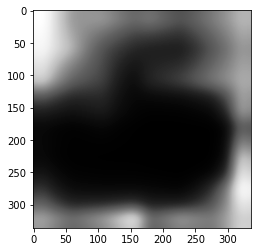

In [88]:
plt.imshow(alpha_smooth)
plt.set_cmap(cm.Greys_r)

In [89]:
# alpha = skimage.transform.resize(np.array(img_caption.alphas[316617])[1,:], [14 * 24, 14 * 24])

In [96]:
pd.DataFrame(alpha_smooth).describe()

0           1           2           3           4           5    \
count  336.000000  336.000000  336.000000  336.000000  336.000000  336.000000   
mean     0.008892    0.008896    0.008904    0.008915    0.008929    0.008943   
std      0.007616    0.007619    0.007625    0.007634    0.007643    0.007654   
min      0.000588    0.000589    0.000590    0.000591    0.000593    0.000595   
25%      0.001469    0.001469    0.001472    0.001475    0.001479    0.001483   
50%      0.006591    0.006594    0.006602    0.006612    0.006624    0.006637   
75%      0.016878    0.016886    0.016900    0.016920    0.016944    0.016970   
max      0.020982    0.020992    0.021012    0.021040    0.021074    0.021110   

              6           7           8           9    ...         326  \
count  336.000000  336.000000  336.000000  336.000000  ...  336.000000   
mean     0.008957    0.008970    0.008979    0.008984  ...    0.012469   
std      0.007665    0.007674    0.007681    0.007685  ...    0.003263   
min      0.000597    0.000598    0.000599    0.000600  ...    0.006404   
25%      0.001488    0.001491    0.001494    0.001496  ...    0.010732   
50%      0.006650    0.006662    0.006670    0.006675  ...    0.011723   
75%      0.016996    0.017018    0.017035    0.017044  ...    0.015120   
max      0.021145    0.021177    0.021200    0.021212  ...    0.019065   

              327         328         329         330         331         332  \
count  336.000000  336.000000  336.000000  336.000000  336.000000  336.000000   
mean     0.012456    0.012431    0.012397    0.012359    0.012320    0.012284   
std      0.003259    0.003253    0.003245    0.003236    0.003227    0.003219   
min      0.006392    0.006368    0.006336    0.006300    0.006263    0.006229   
25%      0.010724    0.010712    0.010690    0.010665    0.010644    0.010622   
50%      0.011718    0.011705    0.011679    0.011663    0.011646    0.011621   
75%      0.015105    0.015090    0.015069    0.015035    0.015011    0.014986   
max      0.019042    0.018997    0.018936    0.018868    0.018798    0.018734   

              333         334         335  
count  336.000000  336.000000  336.000000  
mean     0.012254    0.012233    0.012222  
std      0.003212    0.003207    0.003205  
min      0.006200    0.006180    0.006169  
25%      0.010610    0.010599    0.010593  
50%      0.011603    0.011594    0.011590  
75%      0.014967    0.014954    0.014947  
max      0.018680    0.018642    0.018621  

[8 rows x 336 columns]

In [90]:
alpha

array([[0.01934058, 0.01962673, 0.01991287, ..., 0.01190936, 0.01179075,
        0.01167213],
       [0.01936432, 0.0196536 , 0.01994288, ..., 0.01196938, 0.01185155,
        0.01173371],
       [0.01938807, 0.01968048, 0.01997289, ..., 0.01202941, 0.01191235,
        0.01179529],
       ...,
       [0.00951686, 0.00962956, 0.00974225, ..., 0.01458468, 0.01435228,
        0.01411987],
       [0.00926052, 0.00937345, 0.00948639, ..., 0.01464971, 0.01440802,
        0.01416634],
       [0.00900417, 0.00911734, 0.00923052, ..., 0.01471473, 0.01446377,
        0.01421281]])

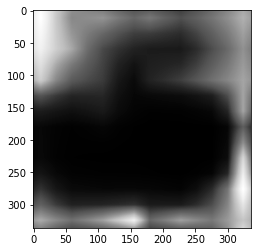

In [85]:
plt.imshow(alpha)
plt.set_cmap(cm.Greys_r)

In [57]:
np.array(img_caption.alphas[31093])

array([9488,    1,    2,   11,    1,  287,   86,   14,   37,   17,    1,
       1490, 9489])

In [16]:
#img_caption.produce_counterfactuals(316617)

In [15]:
# img_caption.ids

In [16]:
pwd

'/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/src'

In [15]:
img_id = 316617
ann_id = img_caption.ids[img_id][0]

In [19]:
model_fp

'models/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'

In [21]:
img_dir = '../data/temp/imgs'
out_dir = '../data/out'
model_dir = 'full_model_coco2017_v2'

In [17]:
wordmap_fp

'models/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json'

In [ ]:
data_dir = 'data/imgs'
out_dir = 'data/out'
for img_folder in tqdm(os.listdir(data_dir)):
    load_fp = data_dir+'/'+img_folder
    for file in tqdm(os.listdir(f'{data_dir}/{img_folder}')):
        in_fp = load_fp+'/'+file
        out_fp = out_dir+'/'+img_folder+'/'
        if 'raw' in file:
            out_fp+='maps_raw.png'
#             print(out_fp)
            get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth)
#         if 'output' in file:

In [18]:
img_caption.raw_imgs

['../data/temp/imgs/31093/raw.png',
 '../data/temp/imgs/311909/raw.png',
 '../data/temp/imgs/466156/raw.png',
 '../data/temp/imgs/295316/raw.png',
 '../data/temp/imgs/491464/raw.png',
 '../data/temp/imgs/551215/raw.png',
 '../data/temp/imgs/548555/raw.png',
 '../data/temp/imgs/326542/raw.png',
 '../data/temp/imgs/25394/raw.png',
 '../data/temp/imgs/316617/raw_316617.png',
 '../data/temp/imgs/455624/raw.png']

In [20]:
img_caption.out_dir

'../data/out'

In [ ]:
def get_viz(wordmap_fp, img_fp, beam_size, fname, smooth, visualize=True):


In [27]:
img_id = 316617
for ann_id in img_caption.ids[img_id]:
    in_fp = f'{img_caption.img_dir}/{img_id}/raw_{img_id}.png'
    out_fp = f'{img_caption.out_dir}/{img_id}/maps_raw_{img_id}.png'
    get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=True)    
    #     !./generate_counterfactual.sh {img_dir} {out_dir} {img_id} {ann_id} {model_dir}

../src/caption.py:176: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)


In [69]:
%time img_caption.produce_counterfactuals(316617)

{self.img_dir}
{self.img_dir}/imgs/{img_id}/input_{ann_id}.png
{self.img_dir}/imgs/{img_id}/mask_{ann_id}.png
{self.img_dir}/out/{img_id}/output_{ann_id}.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of nump

Instructions for updating:
Use the retry module or similar alternatives.
---------------------------------- APP CONFIG ----------------------------------
num_gpus_per_job: 1
num_cpus_per_job: 4
num_hosts_per_job: 1
memory_per_job: 32
gpu_type: geforce-rtx-2070super
name: coco2017_gated_conv_v100
model_restore: 
dataset: coco2017
random_crop: True
val: True
log_dir: logs/full_model_coco2017
gan: sngan
gan_loss_alpha: 1
gan_with_mask: True
discounted_mask: True
random_seed: False
padding: SAME
train_spe: 4000
max_iters: 100000000
viz_max_out: 10
val_psteps: 2000
data_flist: 
  coco2017: ['data_flist/coco2017_train_shuffled.flist', 'data_flist/coco2017_validation_shuffled.flist']
  celebahq: ['data/celeba_hq/train_shuffled.flist', 'data/celeba_hq/validation_static_view.flist']
  celeba: ['data/celeba/train_shuffled.flist', 'data/celeba/validation_static_view.flist']
  places2: ['data/places2/train_shuffled.flist', 'data/places2/validation_static_view.flist']
  imagenet: ['data/imagenet/tr

{self.img_dir}
{self.img_dir}/imgs/{img_id}/input_{ann_id}.png
{self.img_dir}/imgs/{img_id}/mask_{ann_id}.png
{self.img_dir}/out/{img_id}/output_{ann_id}.png
{self.img_dir}
{self.img_dir}/imgs/{img_id}/input_{ann_id}.png
{self.img_dir}/imgs/{img_id}/mask_{ann_id}.png
{self.img_dir}/out/{img_id}/output_{ann_id}.png
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jdlevy/anaconda3/envs/py36/lib/python3.6/site-p

In [145]:
img_caption.get_bert_similarities()

../data/temp/imgs/31093/raw.png
../data/temp/imgs/31093/mask_638282.png
../data/temp/imgs/31093/mask_1233457.png
../data/temp/imgs/31093/input_1233457.png
../data/temp/imgs/31093/input_1475365.png
../data/temp/imgs/31093/mask_2157893.png
../data/temp/imgs/31093/input_2157893.png
../data/temp/imgs/31093/mask_1475365.png
../data/temp/imgs/31093/input_638282.png
../data/temp/imgs/31093/input_1421746.png
../data/temp/imgs/31093/input_453234.png
../data/temp/imgs/31093/mask_453234.png
../data/temp/imgs/31093/mask_1421746.png
../data/temp/imgs/311909/raw.png
../data/temp/imgs/311909/input_166445.png
../data/temp/imgs/311909/mask_166445.png
../data/temp/imgs/466156/raw.png
../data/temp/imgs/466156/mask_1358425.png
../data/temp/imgs/466156/input_1344825.png
../data/temp/imgs/466156/input_135585.png
../data/temp/imgs/466156/mask_243663.png
../data/temp/imgs/466156/input_47170.png
../data/temp/imgs/466156/input_243663.png
../data/temp/imgs/466156/input_1358425.png
../data/temp/imgs/466156/mask_1

  0%|          | 0/36 [00:00<?, ?it/s]

../data/temp/imgs/455624/mask_1306826.png
../data/temp/imgs/455624/mask_1267460.png
../data/temp/imgs/455624/input_1258992.png


100%|██████████| 36/36 [00:55<00:00,  1.55s/it]


raw_caption  img_id        ann_id  \
0    a man riding a skateboard up the side of a ramp   31093        638282   
1    a man riding a skateboard up the side of a ramp   31093       1233457   
2    a man riding a skateboard up the side of a ramp   31093       1475365   
3    a man riding a skateboard up the side of a ramp   31093       2157893   
4    a man riding a skateboard up the side of a ramp   31093       1421746   
5    a man riding a skateboard up the side of a ramp   31093        453234   
6       a blue and white bus parked in a parking lot  311909        166445   
7                 a cat sitting on the hood of a car  466156       1358425   
8                 a cat sitting on the hood of a car  466156       1344825   
9                 a cat sitting on the hood of a car  466156        135585   
10                a cat sitting on the hood of a car  466156        243663   
11                a cat sitting on the hood of a car  466156         47170   
12         a man riding a wave on top of a surfboard  295316        513030   
13         a man riding a wave on top of a surfboard  295316       2091801   
14         a man riding a wave on top of a surfboard  295316        475564   
15         a man riding a wave on top of a surfboard  295316        650345   
16         a man riding a wave on top of a surfboard  295316        647066   
17         a man riding a wave on top of a surfboard  295316        540500   
18         a man riding a wave on top of a surfboard  295316        649626   
19         a man riding a wave on top of a surfboard  295316        542546   
20     a young boy holding a baseball bat on a field  491464       1382027   
21     a young boy holding a baseball bat on a field  491464       1385051   
22     a young boy holding a baseball bat on a field  491464       1343081   
23     a young boy holding a baseball bat on a field  491464       1345512   
24     a young boy holding a baseball bat on a field  491464       1339021   
25     a young boy holding a baseball bat on a field  491464       2044396   
26     a young boy holding a baseball bat on a field  491464       1357559   
27     a young boy holding a baseball bat on a field  491464       2041265   
28     a young boy holding a baseball bat on a field  491464        629786   
29     a young boy holding a baseball bat on a field  491464       2043134   
30     a young boy holding a baseball bat on a field  491464       1383630   
31     a young boy holding a baseball bat on a field  491464       1776076   
32     a young boy holding a baseball bat on a field  491464        437864   
33  a man holding a tennis racquet on a tennis court  551215        660482   
34  a man holding a tennis racquet on a tennis court  551215        448133   
35       a hot dog with ketchup and mustard on a bun  548555       1067015   
36       a hot dog with ketchup and mustard on a bun  548555        451571   
37       a man riding skis down a snow covered slope  326542        437575   
38       a man riding skis down a snow covered slope  326542        447851   
39       a man riding skis down a snow covered slope  326542        606707   
40       a man riding skis down a snow covered slope  326542       1714084   
41     a man sitting at a table with a glass of wine   25394       1494928   
42          a man riding on the back of a motorcycle  455624       1290751   
43          a man riding on the back of a motorcycle  455624       1726671   
44          a man riding on the back of a motorcycle  455624       1299441   
45          a man riding on the back of a motorcycle  455624       1250069   
46          a man riding on the back of a motorcycle  455624       1306826   
47          a man riding on the back of a motorcycle  455624       1236186   
48          a man riding on the back of a motorcycle  455624       1267460   
49          a man riding on the back of a motorcycle  455624       1287370   
50          a man riding on the back of a motorcycle  455624   

In [26]:
img_caption.raw_imgs

['../data/temp/imgs/31093/raw.png',
 '../data/temp/imgs/311909/raw.png',
 '../data/temp/imgs/466156/raw.png',
 '../data/temp/imgs/295316/raw.png',
 '../data/temp/imgs/491464/raw.png',
 '../data/temp/imgs/551215/raw.png',
 '../data/temp/imgs/548555/raw.png',
 '../data/temp/imgs/326542/raw.png',
 '../data/temp/imgs/25394/raw.png',
 '../data/temp/imgs/316617/raw_316617.png',
 '../data/temp/imgs/455624/raw.png']

In [96]:
img_caption.counterfactuals

['../data/out/31093/output_2157893.png',
 '../data/out/31093/output_1233457.png',
 '../data/out/31093/output_453234.png',
 '../data/out/31093/output_638282.png',
 '../data/out/31093/output_1421746.png',
 '../data/out/31093/output_1475365.png',
 '../data/out/311909/output_166445.png',
 '../data/out/466156/output_135585.png',
 '../data/out/466156/output_243663.png',
 '../data/out/466156/output_1358425.png',
 '../data/out/466156/output_47170.png',
 '../data/out/466156/output_1344825.png',
 '../data/out/295316/output_513030.png',
 '../data/out/295316/output_649626.png',
 '../data/out/295316/output_542546.png',
 '../data/out/295316/output_647066.png',
 '../data/out/295316/output_650345.png',
 '../data/out/295316/output_2091801.png',
 '../data/out/295316/output_475564.png',
 '../data/out/295316/output_540500.png',
 '../data/out/491464/output_1343081.png',
 '../data/out/491464/output_1382027.png',
 '../data/out/491464/output_437864.png',
 '../data/out/491464/output_2041265.png',
 '../data/out

In [95]:
img_caption.img_ids

[31093, 311909, 466156, 295316, 491464, 551215, 548555, 326542, 25394, 455624]

In [82]:
img_caption.get_bert_similarities()

100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


raw_caption  img_id        ann_id  \
0    a man riding a skateboard up the side of a ramp   31093       2157893   
1    a man riding a skateboard up the side of a ramp   31093       1233457   
2    a man riding a skateboard up the side of a ramp   31093        453234   
3    a man riding a skateboard up the side of a ramp   31093        638282   
4    a man riding a skateboard up the side of a ramp   31093       1421746   
5    a man riding a skateboard up the side of a ramp   31093       1475365   
6       a blue and white bus parked in a parking lot  311909        166445   
7                 a cat sitting on the hood of a car  466156        135585   
8                 a cat sitting on the hood of a car  466156        243663   
9                 a cat sitting on the hood of a car  466156       1358425   
10                a cat sitting on the hood of a car  466156         47170   
11                a cat sitting on the hood of a car  466156       1344825   
12         a man riding a wave on top of a surfboard  295316        513030   
13         a man riding a wave on top of a surfboard  295316        649626   
14         a man riding a wave on top of a surfboard  295316        542546   
15         a man riding a wave on top of a surfboard  295316        647066   
16         a man riding a wave on top of a surfboard  295316        650345   
17         a man riding a wave on top of a surfboard  295316       2091801   
18         a man riding a wave on top of a surfboard  295316        475564   
19         a man riding a wave on top of a surfboard  295316        540500   
20     a young boy holding a baseball bat on a field  491464       1343081   
21     a young boy holding a baseball bat on a field  491464       1382027   
22     a young boy holding a baseball bat on a field  491464        437864   
23     a young boy holding a baseball bat on a field  491464       2041265   
24     a young boy holding a baseball bat on a field  491464       1776076   
25     a young boy holding a baseball bat on a field  491464       1383630   
26     a young boy holding a baseball bat on a field  491464       1357559   
27     a young boy holding a baseball bat on a field  491464       2043134   
28     a young boy holding a baseball bat on a field  491464       1345512   
29     a young boy holding a baseball bat on a field  491464       2044396   
30     a young boy holding a baseball bat on a field  491464        629786   
31     a young boy holding a baseball bat on a field  491464       1385051   
32     a young boy holding a baseball bat on a field  491464       1339021   
33  a man holding a tennis racquet on a tennis court  551215        448133   
34  a man holding a tennis racquet on a tennis court  551215        660482   
35       a hot dog with ketchup and mustard on a bun  548555        451571   
36       a hot dog with ketchup and mustard on a bun  548555       1067015   
37       a man riding skis down a snow covered slope  326542        447851   
38       a man riding skis down a snow covered slope  326542        437575   
39       a man riding skis down a snow covered slope  326542        606707   
40       a man riding skis down a snow covered slope  326542       1714084   
41     a man sitting at a table with a glass of wine   25394       1494928   
42          a man riding on the back of a motorcycle  455624       2009022   
43          a man riding on the back of a motorcycle  455624        150782   
44          a man riding on the back of a motorcycle  455624       1726671   
45          a man riding on the back of a motorcycle  455624       1307331   
46          a man riding on the back of a motorcycle  455624       1267225   
47          a man riding on the back of a motorcycle  455624       1287370   
48          a man riding on the back of a motorcycle  455624       1290751   
49          a man riding on the back of a motorcycle  455624       1306826   
50          a man riding on the back of a motorcycle  455624   

In [13]:
def get_captions(data_dir, out_dir):
    caption_dict = {}
    for img_folder in tqdm(os.listdir(data_dir)):
        load_fp = data_dir+'/'+img_folder
        for file in tqdm(os.listdir(f'{data_dir}/{img_folder}')):
            in_fp = load_fp+'/'+file
            out_fp = out_dir+'/'+img_folder+'/'
            if 'raw' in file and 'out' not in data_dir:
                out_fp+=f'maps_raw_{img_folder}.png'
                caption_dict[int(img_folder)] = get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
            if 'output' in file:
                ann_id = file.split('_')[-1].strip('.png')
                out_fp+=f'maps_{ann_id}.png'
                words = get_viz(wordmap_fp, in_fp, beam_size, out_fp, smooth, visualize=False)
                caption_dict[(int(img_folder), int(ann_id))] = [words]
    return caption_dict

In [39]:
def get_bert_similarities(data_dir, out_dir):
    raw_caption_dict = get_captions(data_dir, out_dir)
    ann_caption_dict = get_captions(out_dir, out_dir)
    
    ann_df = pd.DataFrame(ann_caption_dict).transpose().reset_index().rename(columns={0:'ann_caption'})
    caption_df = pd.Series(raw_caption_dict).to_frame().rename(columns={0:'raw_caption'}).merge(ann_df, left_index=True, right_on='level_0')
    caption_df = caption_df.rename(columns={'level_0':'img_id', 'level_1':'ann_id'})
    
    caption_df.loc[(caption_df['raw_caption'] == caption_df['ann_caption']), 'dist_from_raw'] = 0
    caption_df.loc[list(caption_df['dist_from_raw'].isnull().index), 'dist_from_raw'] = \
        caption_df.loc[(caption_df['dist_from_raw'].isnull())].progress_apply(lambda x: compare_two_sentences(x['raw_caption'], x['ann_caption']), axis=1)
    caption_df['dist_from_raw'] = caption_df['dist_from_raw'].fillna(0)
    return caption_df

In [73]:
data_dir = '../data/temp/imgs'
out_dir = '../data/out'

In [41]:
%time caption_df = get_bert_similarities(data_dir, out_dir)

100%|██████████| 13/13 [00:00<00:00, 162.31it/s]

100%|██████████| 11/11 [00:00<00:00, 218.89it/s]

100%|██████████| 27/27 [00:00<00:00, 516.06it/s]

100%|██████████| 5/5 [00:00<00:00, 103.28it/s]

100%|██████████| 3/3 [00:00<00:00, 53.74it/s]

100%|██████████| 3/3 [00:00<00:00, 57.68it/s]

100%|██████████| 23/23 [00:00<00:00, 424973.53it/s]

100%|██████████| 5/5 [00:00<00:00, 61.44it/s]

100%|██████████| 2/2 [00:00<00:00, 32.97it/s]

100%|██████████| 9/9 [00:14<00:00,  1.56s/it]

CPU times: user 1min 1s, sys: 2.08 s, total: 1min 3s
Wall time: 17.4 s


In [38]:
# raw_caption_dict = get_captions('../data/temp/imgs', '../data/out')
# ann_caption_dict = get_captions('../data/out', '../data/out')

In [24]:
ann_df = pd.DataFrame(ann_caption_dict).transpose().reset_index().rename(columns={0:'ann_caption'})
caption_df = pd.Series(raw_caption_dict).to_frame().rename(columns={0:'raw_caption'}).merge(ann_df, left_index=True, right_on='level_0')
caption_df = caption_df.rename(columns={'level_0':'img_id', 'level_1':'ann_id'})

### BERT

In [103]:
sentences = [
    "This is an awesome book to learn NLP.",
    "DistilBERT is an amazing NLP model.",
    "We can interchangeably use embedding, encoding, or vectorizing.",
]

vectorizer = Vectorizer()
vectorizer.bert(sentences)
vectors_bert = vectorizer.vectors


In [104]:
dist_1 = spatial.distance.cosine(vectors_bert[0], vectors_bert[1])
dist_2 = spatial.distance.cosine(vectors_bert[0], vectors_bert[2])
print('dist_1: {0}, dist_2: {1}'.format(dist_1, dist_2))

dist_1: 0.0, dist_2: 0.042955875396728516


In [9]:
import json

In [13]:
with open('../config/gen_inpaint.json') as f:
    params = json.load(f)
    data_dir = params['data_dir']
    input_dir = params['input_dir']    
    temp_dir = params['temp_dir']    
    out_dir = params['out_dir']    

In [29]:
caption_df.loc[(caption_df['raw_caption'] == caption_df['ann_caption']), 'dist_from_raw'] = 0
caption_df.loc[list(caption_df['dist_from_raw'].isnull().index), 'dist_from_raw'] = \
    caption_df.loc[(caption_df['dist_from_raw'].isnull())].progress_apply(lambda x: compare_two_sentences(x['raw_caption'], x['ann_caption']), axis=1)
caption_df['dist_from_raw'] = caption_df['dist_from_raw'].fillna(0)

In [31]:
tqdm.pandas()

100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


In [35]:
caption_df

raw_caption  img_id        ann_id  \
0    a man riding a skateboard up the side of a ramp   31093       2157893   
1    a man riding a skateboard up the side of a ramp   31093       1233457   
2    a man riding a skateboard up the side of a ramp   31093        453234   
3    a man riding a skateboard up the side of a ramp   31093        638282   
4    a man riding a skateboard up the side of a ramp   31093       1421746   
5    a man riding a skateboard up the side of a ramp   31093       1475365   
6       a blue and white bus parked in a parking lot  311909        166445   
7                 a cat sitting on the hood of a car  466156        135585   
8                 a cat sitting on the hood of a car  466156        243663   
9                 a cat sitting on the hood of a car  466156       1358425   
10                a cat sitting on the hood of a car  466156         47170   
11                a cat sitting on the hood of a car  466156       1344825   
12         a man riding a wave on top of a surfboard  295316        513030   
13         a man riding a wave on top of a surfboard  295316        649626   
14         a man riding a wave on top of a surfboard  295316        542546   
15         a man riding a wave on top of a surfboard  295316        647066   
16         a man riding a wave on top of a surfboard  295316        650345   
17         a man riding a wave on top of a surfboard  295316       2091801   
18         a man riding a wave on top of a surfboard  295316        475564   
19         a man riding a wave on top of a surfboard  295316        540500   
20     a young boy holding a baseball bat on a field  491464       1343081   
21     a young boy holding a baseball bat on a field  491464       1382027   
22     a young boy holding a baseball bat on a field  491464        437864   
23     a young boy holding a baseball bat on a field  491464       2041265   
24     a young boy holding a baseball bat on a field  491464       1776076   
25     a young boy holding a baseball bat on a field  491464       1383630   
26     a young boy holding a baseball bat on a field  491464       1357559   
27     a young boy holding a baseball bat on a field  491464       2043134   
28     a young boy holding a baseball bat on a field  491464       1345512   
29     a young boy holding a baseball bat on a field  491464       2044396   
30     a young boy holding a baseball bat on a field  491464        629786   
31     a young boy holding a baseball bat on a field  491464       1385051   
32     a young boy holding a baseball bat on a field  491464       1339021   
33  a man holding a tennis racquet on a tennis court  551215        448133   
34  a man holding a tennis racquet on a tennis court  551215        660482   
35       a hot dog with ketchup and mustard on a bun  548555        451571   
36       a hot dog with ketchup and mustard on a bun  548555       1067015   
37       a man riding skis down a snow covered slope  326542        447851   
38       a man riding skis down a snow covered slope  326542        437575   
39       a man riding skis down a snow covered slope  326542        606707   
40       a man riding skis down a snow covered slope  326542       1714084   
41     a man sitting at a table with a glass of wine   25394       1494928   
42          a man riding on the back of a motorcycle  455624       2009022   
43          a man riding on the back of a motorcycle  455624        150782   
44          a man riding on the back of a motorcycle  455624       1726671   
45          a man riding on the back of a motorcycle  455624       1307331   
46          a man riding on the back of a motorcycle  455624       1267225   
47          a man riding on the back of a motorcycle  455624       1287370   
48          a man riding on the back of a motorcycle  455624       1290751   
49          a man riding on the back of a motorcycle  455624       1306826   
50          a man riding on the back of a motorcycle  455624   

In [121]:
# cap
tion_df.loc[caption_df['level_0']==466156]

raw_caption  level_0  level_1  \
7   a cat sitting on the hood of a car   466156   135585   
8   a cat sitting on the hood of a car   466156   243663   
9   a cat sitting on the hood of a car   466156  1358425   
10  a cat sitting on the hood of a car   466156    47170   
11  a cat sitting on the hood of a car   466156  1344825   

                                          ann_caption  dist_from_raw  
7   a black and white dog standing next to a black...       0.031496  
8                  a cat sitting on the hood of a car       0.000000  
9                  a cat sitting on the hood of a car       0.000000  
10  a couple of motorcycles parked next to each other       0.076799  
11                 a cat sitting on the hood of a car       0.000000

In [132]:
pwd

'/home/jdlevy/Documents/UCSD/Senior/Quarter 2/DSC 180B/180b_capstone_xai/src'